# Optimization for Machine Learning: Computer Lab 1

**MOREIRA TEIXEIRA Luiz Fernando**

**OLM REZENDE Mariana**

## 2. Preprocessing the data

Here, we load the data, standardize it, and set it in the appropriate shape for performing linear regression. You do not need to complete anything in this section; however it is important that you understand what the code is doing. See the pdf instructions for more details.

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# Loading data
data_matrix_train, COP_train, data_matrix_test, COP_test, names = np.load('data_center_data_matrix.npy', allow_pickle=True)

In [11]:
# centering and normalizing the matrix
matrix_mean = np.mean(data_matrix_train, axis=0)
M = data_matrix_train - matrix_mean

matrix_std = np.std(M, axis=0)
M = M / matrix_std
matrix_mean.shape

(892,)

In [12]:
M.shape

(722, 892)

In [13]:
# Building the corresponding matrices A,b for linear regression
A = np.hstack([M, np.ones((M.shape[0],1)), -(M.T * COP_train[:,3]).T])
b = COP_train[:,3]

# Building the same matrices for the test set
M_test = (data_matrix_test - matrix_mean) / matrix_std
A_test = np.hstack([M_test, np.ones((M_test.shape[0],1)), -(M_test.T * COP_test[:,3]).T])
b_test = COP_test[:,3]

d = A.shape[1]

## 3. Ordinary least squares

We now wish to solve the problem
$$
\min_{w \in \mathbb{R}^d} \frac 12 \|Aw-b\|_2^2
$$

### Question 3.1:

Since we know that $Aw = b$ and $ b = y(t)$, we have:

$$
y(t) = \tilde{x}(t)^{T}w_1 + w_0 - y(t) \times \tilde{x}(t)^{T}w_2
$$

Rearranging terms:

$$
y(t) + y(t) \times \tilde{x}(t)^{T}w_2 = \tilde{x}(t)^{T}w_1 + w_0
$$

Factoring out \( y(t) \) on the left-hand side:

$$
y(t) \left( 1 + \tilde{x}(t)^{T}w_2 \right) = \tilde{x}(t)^{T}w_1 + w_0
$$

Dividing through by $\left( 1 + \tilde{x}(t)^{T}w_2 \right)$, assuming $1 + \tilde{x}(t)^{T}w_2 \neq 0 $, we get:

$$
y(t) = \frac{\tilde{x}(t)^{T}w_1 + w_0}{1 + \tilde{x}(t)^{T}w_2}
$$


In [14]:
## Question 3.2: solve with the numpy least squares solver
w_least_squares, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
training_error = np.mean((A @ w_least_squares - b) ** 2)
print(f"Training MSE: {training_error}")

Training MSE: 1.2590797762290833e-27


In [15]:
## Question 3.3

# COMPLETE HERE
test_error = np.mean((A_test @ w_least_squares - b_test)**2)
print("Test error for least squares solution : ", test_error)

Test error for least squares solution :  780.8984793523921


### Adding $\ell_2$ regularization

In order to improve the performance on the test set, we add $\ell_2$ regularization:

$$
\min_{w \in \mathbb{R}^d} \frac 12 \|Aw-b\|_2^2 + \frac \lambda 2 \|w\|_2^2
$$

### Question 3.4:

To check the convexity of the function, let's analyze its Hessian and verify if it's positive semi-definite:

$$
f(w) = \frac{1}{2} \|Aw - b\|_2^2 + \frac{\lambda}{2} \|w\|_2^2
$$

#### Gradient and Hessian:

The gradient of $f(w)$ is:

$$
\nabla f(w) = A^T(Aw - b) + \lambda w
$$

The Hessian is:

$$
\nabla^2 f(w) = A^T A + \lambda I
$$

Since $A^T A$ is symmetric and positive semi-definite (as $x^T A^T A x \geq 0$ for all $x$, which can be rewritten as $(Ax)^T(Ax) = \|Ax\|_2^2$), and $\lambda I$ is also positive semi-definite for $\lambda > 0$, it follows that:

$$
\nabla^2 f(w) = A^T A + \lambda I
$$ 

is positive semi-definite. Thus, $f(w)$ is convex.

#### Strong Convexity:

To further show that $f(w)$ is $\lambda$-strongly convex, we use the definition:

A function $f(w)$ is $\lambda$-strongly convex if:

$$
f(w) - \frac{\lambda}{2}\|w\|_2^2
$$

is convex.

Substituting $f(w)$:

$$
f(w) - \frac{\lambda}{2}\|w\|_2^2 = \frac{1}{2} \|Aw - b\|_2^2
$$

The term $\frac{1}{2} \|Aw - b\|_2^2$ is convex, as it is a quadratic function with a positive semi-definite Hessian. Therefore, $f(w)$ is $\lambda$-strongly convex.

#### Gradient Descent Step Size:

Since $f(w)$ is $\lambda$-strongly convex, the step size $\gamma$ for gradient descent is given by:

$$
\gamma = \frac{2}{L + \lambda}
$$

where $L$ is the Lipschitz constant of the gradient, corresponding to the largest eigenvalue of $A^T A + \lambda I$.


In [16]:
lambda_l2 = 1e4

In [17]:
# Question 3.5
def f(w):
    # COMPLETE HERE
    return 0.5 * np.linalg.norm(A @ w - b)**2 + (lambda_l2 / 2) * np.linalg.norm(w)**2
def grad_f(w):
    # COMPLETE HERE
    return A.T @ (A @ w - b) + lambda_l2*w

def gradient_descent(func, w0, gamma, max_iter):
    w = w0.copy()
    
    
    f_values = []
    gradient_norms = []

    for t in range(max_iter):
        # COMPLETE HERE 
        w = w - gamma*grad_f(w)
        
        f_values.append(f(w))
        gradient_norms.append(np.linalg.norm(grad_f(w)))
        
    return w, f_values, gradient_norms

For finding the appropriate step size range, we need to estimate the Lipschitz constant of the gradient.

### Question 3.6:

Since $\nabla f(w)$ is $L$-Lipschitz, we can compute $L$ as:

$$
L = \|A^T A\|_{\text{op}} = \text{max eigenvalue}(A^T A)
$$

where $\|A^T A\|_{\text{op}}$ denotes the operator norm of $A^T A$, which is equal to its largest eigenvalue.


In [18]:
# COMPLETE HERE
v = A.T @ A
L = np.max(np.real(np.linalg.eigvals(v +lambda_l2*np.eye(v.shape[0]))))

In [19]:
# COMPLETE HERE
w0 = np.zeros(A.shape[1])
step_size = 2/(L+lambda_l2)
max_iter = 800

w_GD, f_values_GD, gradient_norms_GD = gradient_descent(f, w0, step_size, max_iter)

We now compute the evolution of function values and gradient norm. 

Text(0, 0.5, 'Function values')

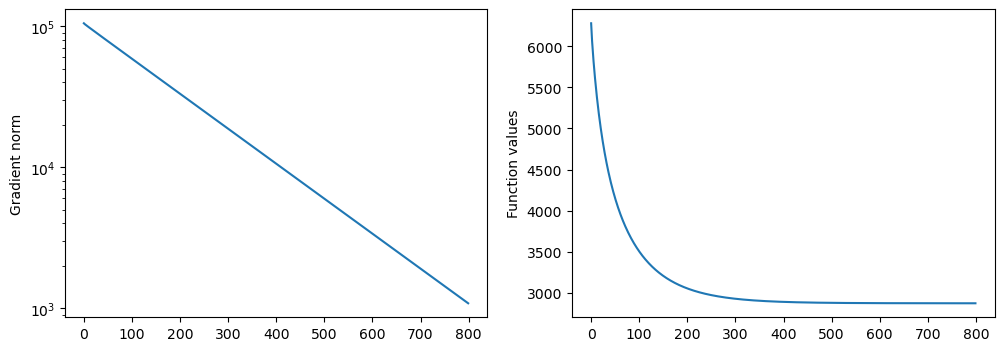

In [20]:
# let us plot the result 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].plot(gradient_norms_GD)
axes[0].semilogy()
axes[0].set_ylabel("Gradient norm")

axes[1].plot(f_values_GD)
axes[1].set_ylabel("Function values")

In [21]:
# Question 3.6 

test_error_l2 = np.mean((A_test @ w_GD - b_test)**2) # COMPLETE HERE
print("Test error for l2 penalized solution : ", test_error_l2)

Test error for l2 penalized solution :  61.47226024528096


What do you observe ? 

A: We can observe that the l2 penalized solution using the gradient descent performs way better than the other solution with least squares. 

For a faster algorithm, we could implement accelerated gradient descent.

In [1]:
# Question 3.7 (optional) 

def accelerated_gradient_descent(func, w0, gamma, max_iter):
    # COMPLETE HERE
    pass

In [ ]:
# COMPLETE HERE
w0 = ...
step_size = ...
max_iter = ...

w_AGD, f_values_AGD, gradient_norms_AGD = accelerated_gradient_descent(f, w0, step_size, max_iter)

In [5]:
# let us plot the result 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].plot(gradient_norms_GD, label = "gradient descent")
axes[0].plot(gradient_norms_AGD, label = "accelerated gradient descent")
axes[0].semilogy()
axes[0].set_ylabel("Gradient norm")
axes[0].legend()

axes[1].plot(f_values_GD, label = "gradient descent")
axes[1].plot(f_values_AGD, label = "accelerated gradient descent")
axes[1].set_ylabel("Function values")
axes[1].legend()

What do you observe regarding the convergence speed ?

## 4. Adding $\ell_1$ regularization (Lasso)

We now solve 

$$
\min_{w \in \mathbb{R}^d} \frac 12 \|Aw-b\|_2^2 + \lambda \|w\|_1
$$

In [6]:
lambda_l1 = 1e3

## Question 4.2
def prox_l1(x, mu = 1.):
    """compute the proximal operator of mu * |x|_1
    """
    # COMPLETE HERE
    return np.sign(x)*np.maximum(np.abs(x)-mu,0)

def F_l1(w, lambda_l1=1e3):
    return np.sum((A @ w - b) ** 2) / 2 + lambda_l1 * np.sum(np.abs(w))

def grad_F_l1(w):
    return A.T @ (A @ w - b)

def proximal_gradient_descent(func, w0, gamma, max_iter):
    w = w0.copy()

    f_values = []
    gradient_norms = []
    for t in range(max_iter):
        w = prox_l1(w - gamma*grad_F_l1(w), lambda_l1 * gamma)
        f_values.append(F_l1(w))
        gradient_norms.append(np.linalg.norm(grad_F_l1(w)))
        
        
    return w, f_values, gradient_norms

In [22]:
# COMPLETE HERE
w0 = np.zeros(A.shape[1])
step_size = 2/(L)
max_iter = 2000

w_PGD, f_values_PGD, gradient_norms_PGD = proximal_gradient_descent(F_l1, w0, step_size, max_iter)

In [23]:
# Question 4.3

test_error_l1 = np.mean((A_test @ w_PGD - b_test)**2)
print("Test error for l1 penalized solution : ", test_error_l1)

Test error for l1 penalized solution :  3.4239662999117737


Compare with the previous test errors. What do you observe?

A: We can see that the proximal gradient descent has so far the best test error.

(1785,)

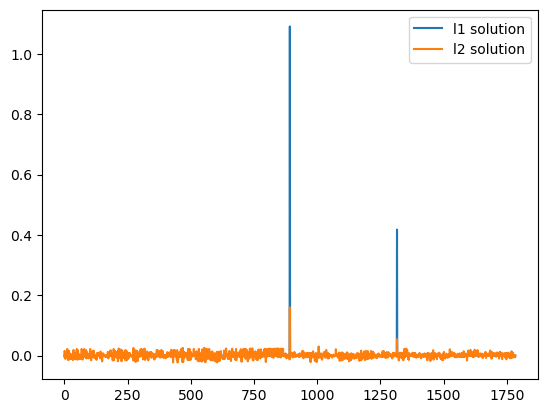

In [24]:
# Let us examine the solution
plt.plot(w_PGD, label = "l1 solution")
plt.plot(w_GD, label = "l2 solution")
plt.legend()
w_PGD.shape

In [25]:
# Question 4.4
def proximal_gradient_descent_linesearch(F_l1, grad_F_l1, prox_l1, w0, lambda_l1, gamma, max_iter, threshold=1e-6):
    """
    Proximal Gradient Descent with Line Search for L1-regularized problems.
    
    """
    w = w0.copy()
    f_values = []
    gradient_norms = []

    for t in range(max_iter):
        gamma_k = gamma
        grad = grad_F_l1(w)
        # Proximal gradient update with tentative step size
        w_k = prox_l1(w - gamma_k * grad, lambda_l1 * gamma_k)

        # Line search to ensure sufficient decrease
        while F_l1(w_k) > F_l1(w) + np.dot(grad, w_k - w) + (1 / (2 * gamma_k)) * np.linalg.norm(w_k - w)**2:
            gamma_k /= 2
            w_k = prox_l1(w - gamma_k * grad, lambda_l1 * gamma_k)

        # Update parameters
        w = w_k
        gamma = 2 * gamma_k  # Adaptive step size for next iteration

        # Record values for analysis
        f_values.append(F_l1(w))
        gradient_norms.append(np.linalg.norm(grad))


    return w, f_values, gradient_norms


In [26]:
w0 = np.zeros(A.shape[1])
gamma = 1/(L)
max_iter = 400

w_PLS, f_values_PLS, gradient_norms_PLS = proximal_gradient_descent_linesearch(F_l1, grad_F_l1, prox_l1, w0, lambda_l1, gamma, max_iter, threshold=1e-6)

In [27]:
test_error_linesearch = np.mean((A_test @ w_PLS - b_test)**2)
print("Test error for l1 penalized solution : ", test_error_linesearch)

Test error for l1 penalized solution :  23.583631923108424


### Question 6.1
We can compare the test errors of each solution and use it as a metric to compare the perfomance of each model.
We can see that in the proximal gradient descent for the lasso problem we achieved the minimum test error, so regarding all the solutions, the proximal gradient descent seems to be the best choice.

## Tuning the penalization parameter

How to find the best solution among all those that were comptued? How to choose the penalization parameter $\lambda$?

In [23]:
# Your method here...